It (Dataset) contains sample data from a hypothetical free to play mobile game. Your task is to use this data set to answer the questions below and prepare a report of your findings. The report should be written to an audience of game and business developers and it will be reviewed on actionability, insightfulness and clarity.

About the Data 

The database contains three tables:
* account (contains user profiles)
* account_date_session (contains in app purchases by the users)
* iap_purchase (contains the number of sessions for the users for the days they have been active)

All the tables contain data for the year of 2016.
You can access the SQLite3 database by command line interface sqlite3. There are also libraries for R and python.
We’d prefer that you complete the assignment using SQL, R, and/or python but feel free to use any tools that you think are suitable for the job. The only criteria is still that the plots you do should be reproducible with the code you are writing.

We will assess the visualisation based on clarity and readability, and your conclusions based on actionability and insightfulness.

The Questions
1. Give us short description of datasets.
2. Analyse the daily active users (DAU):
* Compare DAU changes over time.
* Can you identify any trends in data?
* Can you find any ups or drops that are out of the normal behaviour?
* What do you think why do they happen?
3. Analyse sales:
* Analyse the geographic split of the revenue and the users.
* Calculate average revenue per user per market.
* What are your observations of the results

In [1]:
import sqlite3
import pandas as pd
import  seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

In [2]:
# Connect to the SQLite database
conn = sqlite3.connect('sample.sqlite')

# Create a cursor object to execute SQL queries
cursor = conn.cursor()

# Get the list of tables in the database
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()

# Iterate over tables and fetch data into DataFrames
dfs = {}  # Dictionary to store DataFrames, where keys are table names
for table in tables:
    table_name = table[0]

    # Read data into a DataFrame
    df = pd.read_sql_query(f"SELECT * FROM {table_name};", conn)

    # Store the DataFrame in the dictionary
    dfs[table_name] = df

# Close the cursor and connection when done
cursor.close()
conn.close()

In [3]:
dfs.keys()

dict_keys(['account', 'iap_purchase', 'account_date_session'])

**account contains user profiles**

In [4]:
df_account = dfs['account']
df_account.head(5)

account_id             created_time created_device created_platform  \
0     13514010  2016-03-02 17:11:00.332      iPhone6,2              iOS   
1   4308483975   2016-03-02 20:57:46.14      MIDC147PJ          Android   
2  17193137415  2016-03-02 13:52:16.735       SM-G360F          Android   
3  21488104920  2016-03-02 12:43:27.899        H60-L01          Android   
4  21488107995  2016-03-02 17:20:12.145       GT-I9500          Android   

  country_code  created_app_store_id  
0           GB                     1  
1           FR                     2  
2           IT                     2  
3           CN                     8  
4           RU                     2

Here is a description of each feature:

* account_id: This is a unique identifier for each user account. It is a numeric value.
* created_time: This is the date and time when the user account was created. It is a datetime value.
* created_device: This is the device that the user used to create their account. It can be any model of device that was used to register..
* created_platform: This is the platform that the user used to create their account. It can be one of the following values: "android", "ios".
* country_code: This is the two-letter country code for the user's country. For example, "US" is the country code for the United States.
* created_app_store_id: This is the identifier for the app store that the user used to create their account. This value is only available if the user created their account using an app store app.

In [5]:
def Split_date_time(df, col):
    # Split "created_time" into date and time
    df[['date', 'time']] = df[col].str.split(' ', expand=True)

    df['date'] = pd.to_datetime(df['date'])
    df['time'] = df['time'].str.extract('(\d+:\d+:\d+)')
    df['time'] = pd.to_datetime(df['time'], format='%H:%M:%S').dt.time
    df.drop(col, axis=1, inplace=True)


In [6]:
Split_date_time(df_account, 'created_time')
df_account.head(5)

account_id created_device created_platform country_code  \
0     13514010      iPhone6,2              iOS           GB   
1   4308483975      MIDC147PJ          Android           FR   
2  17193137415       SM-G360F          Android           IT   
3  21488104920        H60-L01          Android           CN   
4  21488107995       GT-I9500          Android           RU   

   created_app_store_id       date      time  
0                     1 2016-03-02  17:11:00  
1                     2 2016-03-02  20:57:46  
2                     2 2016-03-02  13:52:16  
3                     8 2016-03-02  12:43:27  
4                     2 2016-03-02  17:20:12

"created_platform": This feature can be used to understand the distribution of users across different platforms and to target marketing campaigns accordingly. For example, you could use this feature to create targeted ads for Android users.

"country_code": This feature can be used to understand the geographic distribution of users and to tailor marketing messages and product offerings to specific countries. For example, you could use this feature to translate your app into different languages or to offer different pricing options for users in different countries.

"created_app_store_id" feature can be used:

* Identifying app store traffic: By tracking the value of the "created_app_store_id" feature, Supercell can identify which app stores are driving the most new user acquisitions. This information can be used to make informed decisions about where to invest marketing dollars.
* Segmenting users by app store: Supercell can segment its user base by the app store that they used to create their account. This segmentation can be used to tailor marketing messages and product offerings to specific app store audiences.
* Tracking user acquisition campaigns: Supercell can use the "created_app_store_id" feature to track the effectiveness of its user acquisition campaigns. By comparing the number of new users acquired from each app store, Supercell can identify which campaigns are performing best.

"created_time": I separated this feature into two parts: "Date" and "Time". These can be used to analyze user acquisition trends and to identify seasonal patterns. For example, you could use this feature to identify which months or which clocks in the they are the most popular for creating new accounts.

In [7]:
def Info(df, col):
    print(f"{col} has {len(df[col].unique())} different data.")
#     This line will print any unique value for the feature
#     print(sorted(df[col].unique(), key=lambda x: (x is None, x)))
    print()

In [8]:
Info(df_account,'created_app_store_id')
Info(df_account,'created_device')
Info(df_account,'created_platform')
Info(df_account,'country_code')

created_app_store_id has 15 different data.

created_device has 11327 different data.

created_platform has 2 different data.

country_code has 190 different data.



In [9]:
def figure_out_plot(df, col, min_threshold, max_threshold):
    df_temp = df[df[col].isin(df[col].value_counts()[
                            (df[col].value_counts() >= min_threshold) & 
                            (df[col].value_counts() <= max_threshold)].index)]
    plt.xticks(rotation=90)
    plot = sns.countplot(x=col, data=df_temp)
    Bar_Lable(plot,'.0f')

In [10]:
def Bar_Lable(plot,N_Fraction):
    for p in plot.patches:
        plot.annotate(format(p.get_height(), N_Fraction), 
                      (p.get_x() + p.get_width() / 2, p.get_height()), rotation=45,
                    ha='center', va='center', xytext=(0, 10), textcoords='offset points')

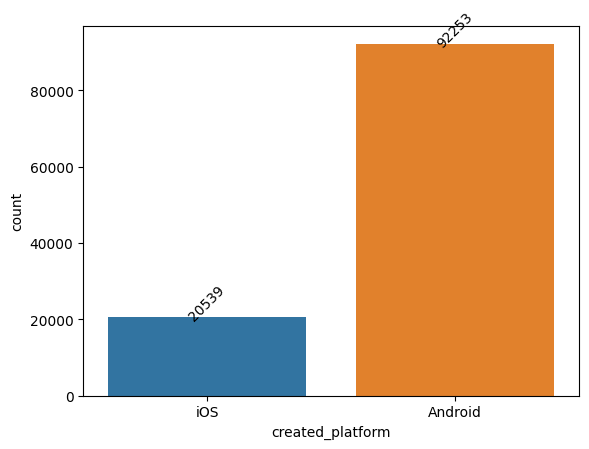

In [11]:
plot = sns.countplot(x='created_platform', data=df_account)
Bar_Lable(plot,'.0f')    

In [12]:
def Figure_value_counts(df, col, min_quantile, max_quantile, title):
    min_thresh = df[col].value_counts().quantile(min_quantile)
    max_thresh = df[col].value_counts().quantile(max_quantile)
    figure_out_plot(df, col, min_thresh, max_thresh)
    plt.title(title)
    plt.show()    

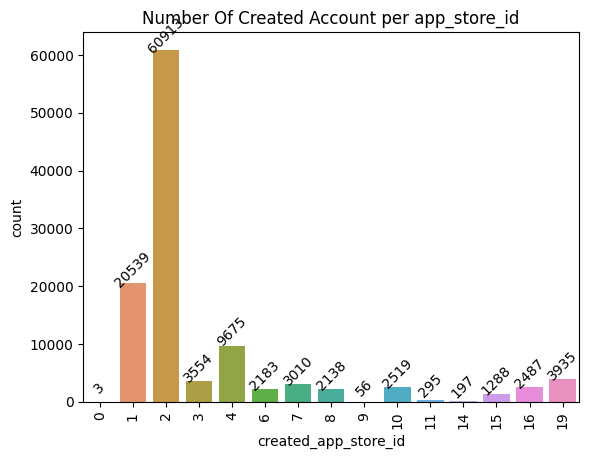

In [13]:
Figure_value_counts(df_account,'created_app_store_id', 0, 1, 'Number Of Created Account per app_store_id')

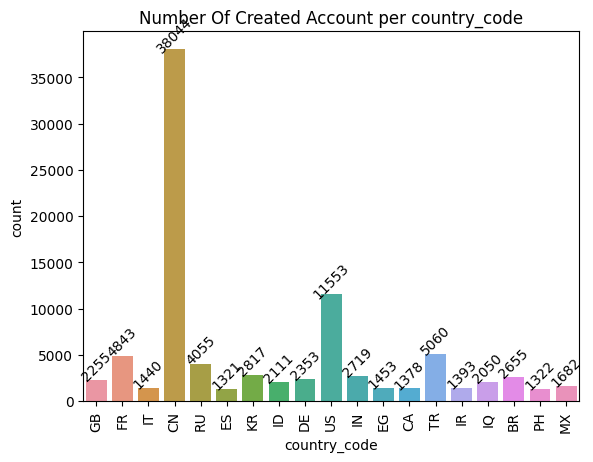

In [14]:
Figure_value_counts(df_account,'country_code', 0.9, 1, 'Number Of Created Account per country_code')

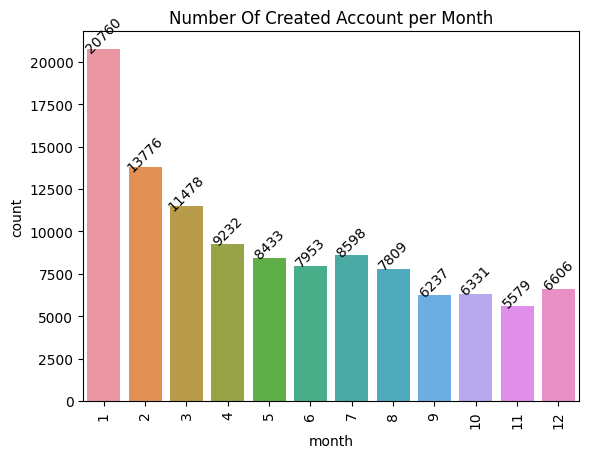

In [15]:
df_account['month'] = df_account['date'].dt.month
Figure_value_counts(df_account,'month', 0, 1, 'Number Of Created Account per Month')
df_account.drop('month', axis=1, inplace=True)

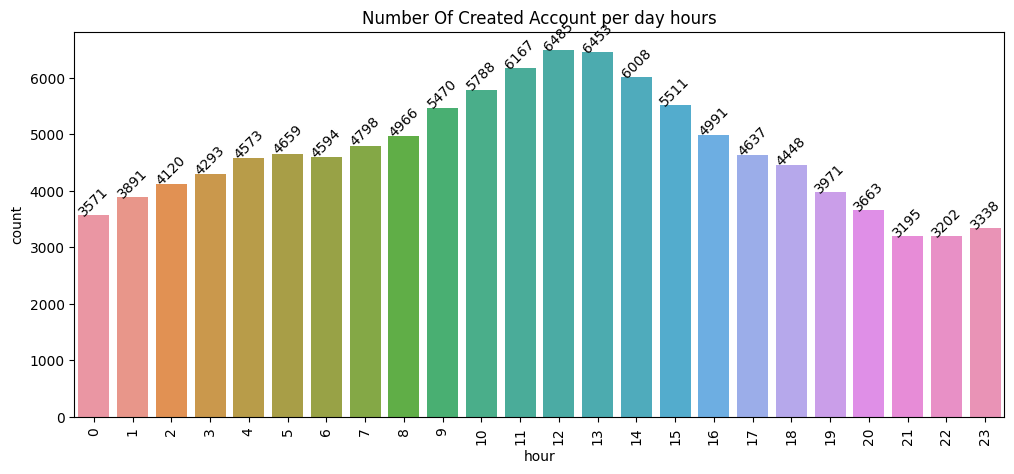

In [16]:
df_account['hour'] = df_account['time'].apply(lambda x: x.hour)
plt.figure(figsize=(12, 5))
Figure_value_counts(df_account,'hour', 0, 1, 'Number Of Created Account per day hours')
df_account.drop('hour', axis=1, inplace=True)

**iap_purchase contains in app purchases by the users**

In [17]:
df_iap_purchase = dfs['iap_purchase']
df_iap_purchase.head(5)

account_id             created_time                   package_id_hash  \
0  30077202816  2016-03-26 23:59:59.355  ae0253c27c34edd1ab4fe21d6bfc91f8   
1  30077202816  2016-05-31 11:24:37.283  dd4c1bda4f2c904075fb2fbfcf30f30e   
2  21487283560  2016-02-13 03:40:28.644  99a9e0e63efa2fdce8fc8de74c66cea9   
3  21487152816  2016-02-28 00:53:26.678  99a9e0e63efa2fdce8fc8de74c66cea9   
4   8602037685  2016-02-11 01:03:04.727  99a9e0e63efa2fdce8fc8de74c66cea9   

   iap_price_usd_cents  app_store_id  
0                  739             0  
1                  369             0  
2                  184             0  
3                  184             0  
4                  184             0

In [18]:
Split_date_time(df_iap_purchase, 'created_time')
df_iap_purchase.head(5)

account_id                   package_id_hash  iap_price_usd_cents  \
0  30077202816  ae0253c27c34edd1ab4fe21d6bfc91f8                  739   
1  30077202816  dd4c1bda4f2c904075fb2fbfcf30f30e                  369   
2  21487283560  99a9e0e63efa2fdce8fc8de74c66cea9                  184   
3  21487152816  99a9e0e63efa2fdce8fc8de74c66cea9                  184   
4   8602037685  99a9e0e63efa2fdce8fc8de74c66cea9                  184   

   app_store_id       date      time  
0             0 2016-03-26  23:59:59  
1             0 2016-05-31  11:24:37  
2             0 2016-02-13  03:40:28  
3             0 2016-02-28  00:53:26  
4             0 2016-02-11  01:03:04

"account_id": This feature can be used to track individual users and to analyze their purchasing behavior. For example, you could use this feature to identify which users are most likely to make in-app purchases or to track the average revenue per user.

"package_id_hash": This feature can be used to identify which in-app purchase products are most popular and to track sales trends for individual products. For example, you could use this feature to identify which in-app purchase products are generating the most revenue or to track the number of units sold for each product.

"package_id_hash": This feature can be used to analyze the pricing of in-app purchase products and to identify which price points are most popular. For example, you could use this feature to identify which price points generate the most revenue or to track the average price of in-app purchases over time.

"app_store_id": This feature can be used to understand the distribution of in-app purchases across different app stores and to identify which app stores are generating the most revenue. For example, you could use this feature to track the percentage of in-app purchases made through each app store or to identify which app stores are driving the most revenue growth.

"created_time": Like previous data frame, I separated this feature into two parts: "Date" and "Time". These can be used to analyze user acquisition trends and to identify seasonal patterns. For example, you could use this feature to identify which months or which clocks in the they are the most popular for purchase.

In [19]:
Info(df_iap_purchase,'account_id')
Info(df_iap_purchase,'package_id_hash')
Info(df_iap_purchase,'app_store_id')

account_id has 1549 different data.

package_id_hash has 10 different data.

app_store_id has 14 different data.



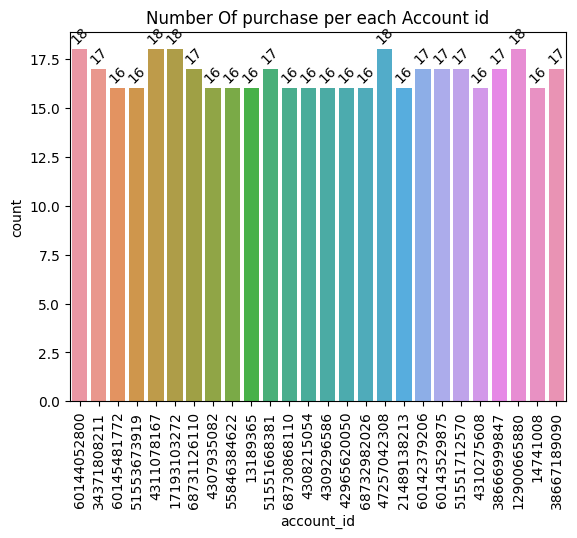

In [20]:
Figure_value_counts(df_iap_purchase,'account_id', 0.91, 0.92, 'Number Of purchase per each Account id')

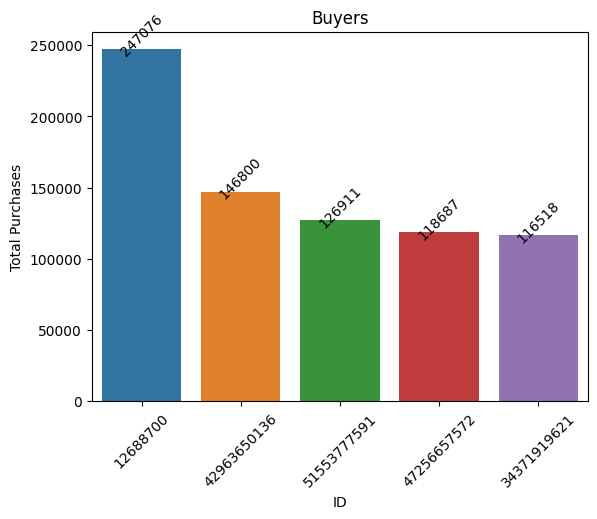

In [21]:
sum_of_purchases = df_iap_purchase.groupby('account_id')['iap_price_usd_cents'].sum().reset_index()
sorted_df = sum_of_purchases.sort_values(by='iap_price_usd_cents', ascending=False)

# Calculate the total sum of purchases
total_purchases = sorted_df['iap_price_usd_cents'].sum()
thresh = 0.2 * total_purchases

# Filter the DataFrame to include only the top n percent
buyers = sorted_df[sorted_df['iap_price_usd_cents'].cumsum() <= thresh]

# a bar plot using seaborn
plot =sns.barplot(x='account_id', y='iap_price_usd_cents', data=buyers)
plt.xticks(rotation=45)
Bar_Lable(plot,'.0f')
plt.title('Buyers')
plt.xlabel('ID')
plt.ylabel('Total Purchases')
plt.show()

# Calculate average revenue per user per market.

In [22]:
revenue_user_market = df_iap_purchase.groupby(['account_id','package_id_hash'])['iap_price_usd_cents'].sum().reset_index()
revenue_user_market

account_id                   package_id_hash  iap_price_usd_cents
0       12322622  99a9e0e63efa2fdce8fc8de74c66cea9                  184
1       12322622  efd2eebfdc98b55f9e6b45915d56f7ac                  144
2       12336472  4a4e0a0d1fa2feec22889320846e580d                 1849
3       12336472  ae0253c27c34edd1ab4fe21d6bfc91f8                16258
4       12348106  99a9e0e63efa2fdce8fc8de74c66cea9                  736
...          ...                               ...                  ...
2541  8606420372  889a7751e98bcc3ac732906403c76411                  110
2542  8606455880  889a7751e98bcc3ac732906403c76411                  110
2543  8606455880  99a9e0e63efa2fdce8fc8de74c66cea9                  184
2544  8606455880  efd2eebfdc98b55f9e6b45915d56f7ac                  180
2545  8606555188  99a9e0e63efa2fdce8fc8de74c66cea9                  184

[2546 rows x 3 columns]

In [23]:
revenue_user_market[revenue_user_market['iap_price_usd_cents'] == revenue_user_market['iap_price_usd_cents'].max()]

account_id                   package_id_hash  iap_price_usd_cents
40   12688700  a2f1e515b0cd1b66de65a9dbfcc7c6df               221940

In [24]:
revenue_user_market[revenue_user_market['iap_price_usd_cents'] == revenue_user_market['iap_price_usd_cents'].min()]

account_id                   package_id_hash  iap_price_usd_cents
27       12508160  efd2eebfdc98b55f9e6b45915d56f7ac                   36
34       12630290  efd2eebfdc98b55f9e6b45915d56f7ac                   36
44       12713850  efd2eebfdc98b55f9e6b45915d56f7ac                   36
53    12897025620  efd2eebfdc98b55f9e6b45915d56f7ac                   36
56    12897113706  efd2eebfdc98b55f9e6b45915d56f7ac                   36
...           ...                               ...                  ...
2488   8604542562  efd2eebfdc98b55f9e6b45915d56f7ac                   36
2509   8605168191  efd2eebfdc98b55f9e6b45915d56f7ac                   36
2510   8605174423  efd2eebfdc98b55f9e6b45915d56f7ac                   36
2517   8605428722  efd2eebfdc98b55f9e6b45915d56f7ac                   36
2528   8605760772  efd2eebfdc98b55f9e6b45915d56f7ac                   36

[319 rows x 3 columns]

In [25]:
df_iap_purchase[(df_iap_purchase['package_id_hash'] == 'a2f1e515b0cd1b66de65a9dbfcc7c6df') & (df_iap_purchase['account_id']=='12688700')]

account_id                   package_id_hash  iap_price_usd_cents  \
7169   12688700  a2f1e515b0cd1b66de65a9dbfcc7c6df                 3699   
7170   12688700  a2f1e515b0cd1b66de65a9dbfcc7c6df                 3699   
7171   12688700  a2f1e515b0cd1b66de65a9dbfcc7c6df                 3699   
7172   12688700  a2f1e515b0cd1b66de65a9dbfcc7c6df                 3699   
7173   12688700  a2f1e515b0cd1b66de65a9dbfcc7c6df                 3699   
7174   12688700  a2f1e515b0cd1b66de65a9dbfcc7c6df                 3699   
7186   12688700  a2f1e515b0cd1b66de65a9dbfcc7c6df                 3699   
7187   12688700  a2f1e515b0cd1b66de65a9dbfcc7c6df                 3699   
7188   12688700  a2f1e515b0cd1b66de65a9dbfcc7c6df                 3699   
7189   12688700  a2f1e515b0cd1b66de65a9dbfcc7c6df                 3699   
7190   12688700  a2f1e515b0cd1b66de65a9dbfcc7c6df                 3699   
7191   12688700  a2f1e515b0cd1b66de65a9dbfcc7c6df                 3699   
7192   12688700  a2f1e515b0cd1b66de65a9dbfcc7c6df                 3699   
7193   12688700  a2f1e515b0cd1b66de65a9dbfcc7c6df                 3699   
7194   12688700  a2f1e515b0cd1b66de65a9dbfcc7c6df                 3699   
7195   12688700  a2f1e515b0cd1b66de65a9dbfcc7c6df                 3699   
7196   12688700  a2f1e515b0cd1b66de65a9dbfcc7c6df                 3699   
7197   12688700  a2f1e515b0cd1b66de65a9dbfcc7c6df                 3699   
7198   12688700  a2f1e515b0cd1b66de65a9dbfcc7c6df                 3699   
7199   12688700  a2f1e515b0cd1b66de65a9dbfcc7c6df                 3699   
7200   12688700  a2f1e515b0cd1b66de65a9dbfcc7c6df                 3699   
7201   12688700  a2f1e515b0cd1b66de65a9dbfcc7c6df                 3699   
7202   12688700  a2f1e515b0cd1b66de65a9dbfcc7c6df                 3699   
7203   12688700  a2f1e515b0cd1b66de65a9dbfcc7c6df                 3699   
7204   12688700  a2f1e515b0cd1b66de65a9dbfcc7c6df                 3699   
7205   12688700  a2f1e515b0cd1b66de65a9dbfcc7c6df                 3699   
7206   12688700  a2f1e515b0cd1b66de65a9dbfcc7c6df                 3699   
7207   12688700  a2f1e515b0cd1b66de65a9dbfcc7c6df                 3699   
7208   12688700  a2f1e515b0cd1b66de65a9dbfcc7c6df                 3699   
7209   12688700  a2f1e515b0cd1b66de65a9dbfcc7c6df                 3699   
7210   12688700  a2f1e515b0cd1b66de65a9dbfcc7c6df                 3699   
7211   12688700  a2f1e515b0cd1b66de65a9dbfcc7c6df                 3699   
7212   12688700  a2f1e515b0cd1b66de65a9dbfcc7c6df                 3699   
7213   12688700  a2f1e515b0cd1b66de65a9dbfcc7c6df                 3699   
7214   12688700  a2f1e515b0cd1b66de65a9dbfcc7c6df                 3699   
7215   12688700  a2f1e515b0cd1b66de65a9dbfcc7c6df                 3699   
7216   12688700  a2f1e515b0cd1b66de65a9dbfcc7c6df                 3699   
7217   12688700  a2f1e515b0cd1b66de65a9dbfcc7c6df                 3699   
7218   12688700  a2f1e515b0cd1b66de65a9dbfcc7c6df                 3699   
7219   12688700  a2f1e515b0cd1b66de65a9dbfcc7c6df                 3699   
7220   12688700  a2f1e515b0cd1b66de65a9dbfcc7c6df                 3699   
7221   12688700  a2f1e515b0cd1b66de65a9dbfcc7c6df                 3699   
7225   12688700  a2f1e515b0cd1b66de65a9dbfcc7c6df                 3699   
7226   12688700  a2f1e515b0cd1b66de65a9dbfcc7c6df                 3699   
7227   12688700  a2f1e515b0cd1b66de65a9dbfcc7c6df                 3699   
7228   12688700  a2f1e515b0cd1b66de65a9dbfcc7c6df                 3699   
7229   12688700  a2f1e515b0cd1b66de65a9dbfcc7c6df                 3699   
7230   12688700  a2f1e515b0cd1b66de65a9dbfcc7c6df                 3699   
7231   12688700  a2f1e515b0cd1b66de65a9dbfcc7c6df                 3699   
7232   12688700  a2f1e515b0cd1b66de65a9dbfcc7c6df                 3699   
7233   12688700  a2f1e515b0cd1b66de65a9dbfcc7c6df                 3699   
7234   12688700  a2f1e515b0cd1b66de65a9dbfcc7c6df                 3699   
7235   12688700  a2f1e515b0cd1b66de65a9dbfcc7c6df                 3699   
7236   12

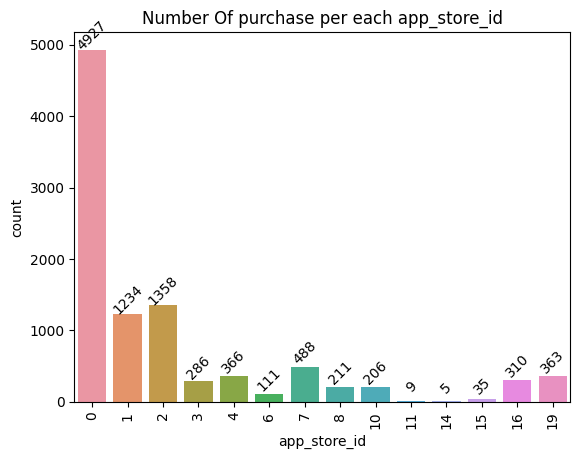

In [26]:
Figure_value_counts(df_iap_purchase,'app_store_id', 0, 1, 'Number Of purchase per each app_store_id')

In [27]:
SOP_per_app_id = df_iap_purchase.groupby('app_store_id')['iap_price_usd_cents'].sum().sort_values(ascending=False).reset_index()
SOP_per_app_id.T

0       1       2       3      4      5      6   \
app_store_id               0       2       1      10      7      3      4   
iap_price_usd_cents  2267872  808720  686596  142244  82318  78450  55726   

                        7      8      9     10    11   12   13  
app_store_id             8     19     16     6    15   11   14  
iap_price_usd_cents  48222  39930  26219  9287  5700  324  254

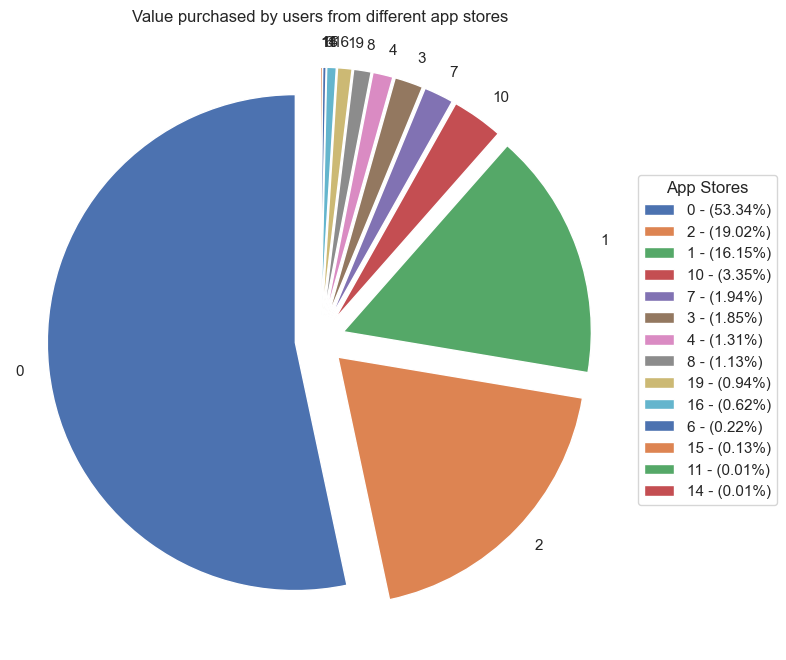

In [28]:
plt.figure(figsize=(8, 10))
sns.set(style="whitegrid")
plt.title("Value purchased by users from different app stores")
wedges, texts = plt.pie(SOP_per_app_id['iap_price_usd_cents'], labels=SOP_per_app_id['app_store_id'], startangle=90, explode=[0.1 for i in range(len(SOP_per_app_id))])

# Custom legend with percentages
legend_labels = [f'{label} - ({100*value/SOP_per_app_id["iap_price_usd_cents"].sum():.2f}%)' for label, value in zip(SOP_per_app_id['app_store_id'], SOP_per_app_id['iap_price_usd_cents'])]
plt.legend(wedges, legend_labels, title="App Stores", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

plt.show()

In [29]:
df_account[df_account['created_app_store_id'] == 0]

account_id   created_device created_platform country_code  \
22848   8602127532           XT1563          Android           BR   
72961  12899245768  Coolpad Y91-921          Android           CN   
72962  60142091659         GT-I9500          Android           TR   

       created_app_store_id       date      time  
22848                     0 2016-01-04  18:26:26  
72961                     0 2016-05-29  04:43:44  
72962                     0 2016-03-04  11:10:24

Something very weird happened here. Users who come from app store "0" are just 3 based on table "account", but they had most purchase, More than half of purchases. After check, I found that "app_store_id" at "df_account" and "df_iap_purchase" are not as same as each other (I dont know why!!)

I demonstrate in next two cells. Account ID "12688700" has the most purchased which has different "app_store_id" in each table.

In [30]:
df_account[df_account['account_id'] == '12688700']

account_id created_device created_platform country_code  \
41359   12688700       IM-A870S          Android           KR   

       created_app_store_id       date      time  
41359                     2 2016-01-16  09:56:28

In [31]:
df_iap_purchase[df_iap_purchase['account_id'] == '12688700']

account_id                   package_id_hash  iap_price_usd_cents  \
7162   12688700  99a9e0e63efa2fdce8fc8de74c66cea9                  184   
7163   12688700  dd4c1bda4f2c904075fb2fbfcf30f30e                  369   
7164   12688700  ae0253c27c34edd1ab4fe21d6bfc91f8                  739   
7165   12688700  dd4c1bda4f2c904075fb2fbfcf30f30e                  369   
7166   12688700  ae0253c27c34edd1ab4fe21d6bfc91f8                  739   
...         ...                               ...                  ...   
7241   12688700  a2f1e515b0cd1b66de65a9dbfcc7c6df                 3699   
7242   12688700  a2f1e515b0cd1b66de65a9dbfcc7c6df                 3699   
7243   12688700  99a9e0e63efa2fdce8fc8de74c66cea9                  184   
7244   12688700  dd4c1bda4f2c904075fb2fbfcf30f30e                  369   
7245   12688700  99a9e0e63efa2fdce8fc8de74c66cea9                  184   

      app_store_id       date      time  
7162             0 2016-01-27  04:28:10  
7163             0 2016-01-27  05:03:18  
7164             0 2016-01-27  05:07:15  
7165             0 2016-01-27  05:10:47  
7166             0 2016-01-27  05:13:12  
...            ...        ...       ...  
7241             0 2016-02-01  11:20:40  
7242             0 2016-02-01  11:21:04  
7243             0 2016-02-08  01:31:53  
7244             0 2016-02-08  01:32:56  
7245             0 2016-02-08  01:33:53  

[84 rows x 6 columns]

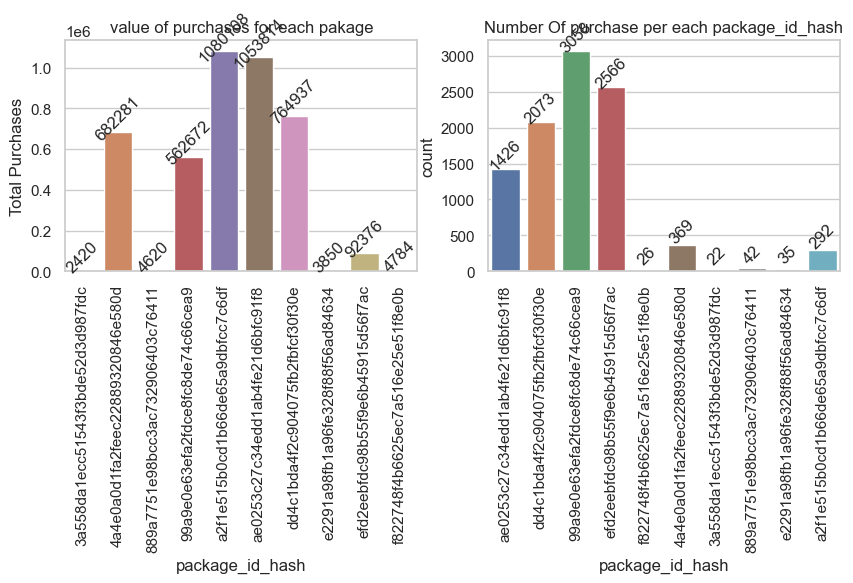

In [32]:
plt.figure(figsize=(10, 3))

plt.subplot(1,2,1)
value_purchase_pakage = df_iap_purchase.groupby('package_id_hash')['iap_price_usd_cents'].sum().reset_index()
value_purchase_pakage = value_purchase_pakage.sort_values(by='package_id_hash').reset_index()

# a bar plot using seaborn
plot =sns.barplot(x='package_id_hash', y='iap_price_usd_cents', data=value_purchase_pakage)
plt.xticks(rotation=90)
Bar_Lable(plot,'.0f')
plt.title('value of purchases for each pakage')
plt.xlabel('package_id_hash')
plt.ylabel('Total Purchases')

plt.subplot(1,2,2)
Figure_value_counts(df_iap_purchase,'package_id_hash', 0, 1, 'Number Of purchase per each package_id_hash')

plt.show()

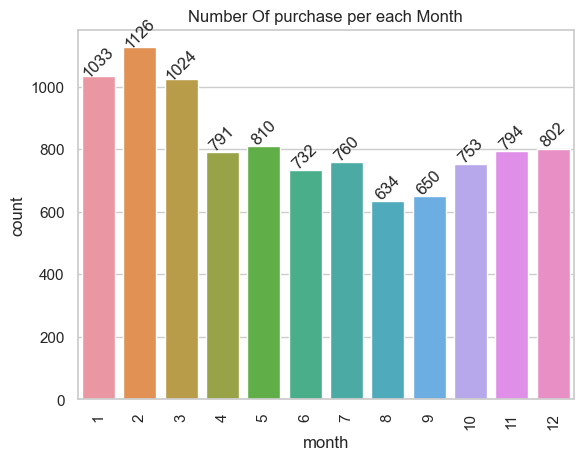

In [33]:
df_iap_purchase['month'] = df_iap_purchase['date'].dt.month
Figure_value_counts(df_iap_purchase,'month', 0, 1, 'Number Of purchase per each Month')
df_iap_purchase.drop('month', axis=1, inplace=True)

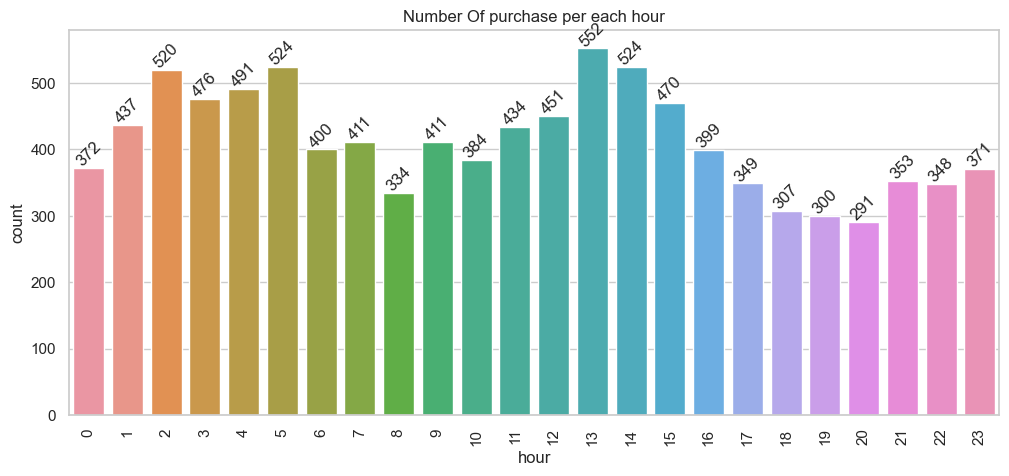

In [34]:
df_iap_purchase['hour'] = df_iap_purchase['time'].apply(lambda x: x.hour)
plt.figure(figsize=(12, 5))
Figure_value_counts(df_iap_purchase,'hour', 0, 1, 'Number Of purchase per each hour')
df_iap_purchase.drop('hour', axis=1, inplace=True)

**account_date_session contains the number of sessions for the users for the days they have been active**

In [35]:
df_account_date_session = dfs['account_date_session']
df_account_date_session.head(5)

account_id        date  session_count  session_duration_sec
0  68730811144  2016-01-01              1                    47
1  68730812806  2016-01-01              1                   204
2  68730829426  2016-01-01             12                  4703
3  68730829426  2016-01-02              9                  4676
4  68730829426  2016-01-03              9                  2271

"date": This feature can be used to analyze user activity trends over time and to identify seasonal patterns. For example, you could use this feature to identify which times of the year are most popular for user sessions or to track the overall level of user activity over time.

"session_count": This feature can be used to measure the overall level of user engagement and to identify trends in user activity. For example, you could use this feature to track the average number of sessions per user per day or to identify which times of the year have the highest number of user sessions.

"session_duration_sec": This feature can be used to measure the average length of user sessions and to identify trends in user engagement. For example, you could use this feature to track the average session duration over time or to identify which times of the year have the longest average session duration.

# Compare DAU changes over time.

In [36]:
sum_of_user_per_day = df_account_date_session['date'].value_counts().sort_index().reset_index()

# Rename the columns to 'date' and 'count'
sum_of_user_per_day.columns = ['date', 'count']

# Calculate the daily changes
sum_of_user_per_day['daily_change'] = sum_of_user_per_day['count'].diff()
sum_of_user_per_day['daily_change'].fillna(0, inplace=True)
sum_of_user_per_day['percentage_change'] = round((sum_of_user_per_day['daily_change'] / sum_of_user_per_day['count'].shift(1)) * 100, 2)
sum_of_user_per_day['percentage_change'].fillna(0, inplace=True)

sum_of_user_per_day

date  count  daily_change  percentage_change
0    2016-01-01   1083           0.0               0.00
1    2016-01-02   1558         475.0              43.86
2    2016-01-03   1872         314.0              20.15
3    2016-01-04   1884          12.0               0.64
4    2016-01-05   2068         184.0               9.77
..          ...    ...           ...                ...
361  2016-12-27   4421          22.0               0.50
362  2016-12-28   4436          15.0               0.34
363  2016-12-29   4493          57.0               1.28
364  2016-12-30   4669         176.0               3.92
365  2016-12-31   4873         204.0               4.37

[366 rows x 4 columns]

In [37]:
# an interactive line chart with Plotly
fig = px.line(sum_of_user_per_day, x='date', y='percentage_change', labels={'percentage_change': 'Percentage Change'})

# information to show
fig.update_traces(hovertemplate='%{x|%Y-%m-%d}: %{y:.2f}%')

fig.update_layout(title='Percentage Change Over Time', xaxis_title='Date', yaxis_title='Percentage Change')
fig.show()

# Can you identify any trends in data?

The data is non-stationary, meaning that the statistical properties of the data change over time. This is evident from the fact that the mean and variance of the data are not constant over time.

There is also a seasonal pattern in the data, with DAU increasing on some days of the week and decreasing on other days of the week. This seasonal pattern is likely due to factors such as people being more likely to use the product on weekends than on weekdays. Also in the summer we don't have any extreme changes.

# Can you find any ups or drops that are out of the normal behaviour?

In [38]:
UperBound = sum_of_user_per_day['daily_change'].mean()+(3 * sum_of_user_per_day['daily_change'].std())
LowerBound = sum_of_user_per_day['daily_change'].mean()-(3 * sum_of_user_per_day['daily_change'].std())

print(f"LowerBound: {round(LowerBound)}, UperBound: {round(UperBound)}")
print(f"min: {sum_of_user_per_day['daily_change'].min()}, Max: {sum_of_user_per_day['daily_change'].max()}")

sum_of_user_per_day[(sum_of_user_per_day['daily_change']<LowerBound) | (sum_of_user_per_day['daily_change']>UperBound)]

LowerBound: -573, UperBound: 594
min: -976.0, Max: 475.0


date  count  daily_change  percentage_change
73   2016-03-14   4305        -976.0             -18.48
157  2016-06-06   4540        -817.0             -15.25

# What do you think why do they happen?

 These could be due to a number of factors, such as a new marketing campaign, a product launch, or a bug in the product or service.
 Also both date were Monday. The first working day of the week and it can effect on number of players.

In [39]:
df_session = df_account_date_session['account_id'].value_counts().sort_values(ascending=False).reset_index()
# Rename the columns to 'account_id' and 'count'
df_session.columns = ['account_id', 'count']
print("Sume of days that each account were active")
df_session

Sume of days that each account were active


account_id  count
0       34371645828    366
1       55845919586    366
2       25781928930    365
3       55845964800    365
4       12897012855    365
...             ...    ...
112446  47259356396      1
112447  47259343868      1
112448  47259338211      1
112449   4311109044      1
112450  55850528526      1

[112451 rows x 2 columns]

In [40]:
min_thresh = df_session['count'].min() # You can replace your peroper minimum days
max_thresh = df_session['count'].max() # You can replace your peroper maximum days

df_temp = df_session[(df_session['count'] >= min_thresh) & (df_session['count'] <= max_thresh)]
print(f"Number of accounts who were active in between {min_thresh} to {max_thresh} days are ", len(df_temp))

Number of accounts who were active in between 1 to 366 days are  112451


In [41]:
sum_of_times = df_account_date_session.groupby('account_id')['session_duration_sec'].sum().sort_values(ascending=False).reset_index()

min_thresh = sum_of_times['session_duration_sec'].min() # You can replace your peroper minimum time per second
max_thresh = sum_of_times['session_duration_sec'].max() # You can replace your peroper maximum time per second
print("Sum of times per second that each account were active")
sum_of_times[(sum_of_times['session_duration_sec'] >= min_thresh) & (sum_of_times['session_duration_sec'] <= max_thresh)]

Sum of times per second that each account were active


account_id  session_duration_sec
0       38667784379               3637620
1        8603524424               3387564
2       47256789468               3080753
3       34371645828               3029838
4       55846716390               2786131
...             ...                   ...
112446  12899437920                     1
112447  25784347204                     1
112448  25782154560                     1
112449  64437830141                     1
112450  17192745540                     1

[112451 rows x 2 columns]

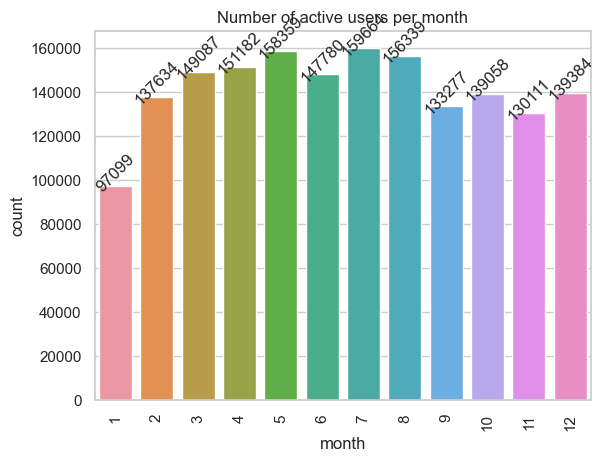

In [42]:
df_account_date_session['date'] = pd.to_datetime(df_account_date_session['date'])
df_account_date_session['month'] = df_account_date_session['date'].dt.month
Figure_value_counts(df_account_date_session,'month', 0, 1, 'Number of active users per month')
df_account_date_session.drop('month', axis=1, inplace=True)

# Analyse the geographic split of the revenue and the users.

In [43]:
df_temp = df_iap_purchase.merge(df_account[['account_id', 'country_code']] , on='account_id', how='left')
df_temp.head(5)

account_id                   package_id_hash  iap_price_usd_cents  \
0  30077202816  ae0253c27c34edd1ab4fe21d6bfc91f8                  739   
1  30077202816  dd4c1bda4f2c904075fb2fbfcf30f30e                  369   
2  21487283560  99a9e0e63efa2fdce8fc8de74c66cea9                  184   
3  21487152816  99a9e0e63efa2fdce8fc8de74c66cea9                  184   
4   8602037685  99a9e0e63efa2fdce8fc8de74c66cea9                  184   

   app_store_id       date      time country_code  
0             0 2016-03-26  23:59:59           US  
1             0 2016-05-31  11:24:37           US  
2             0 2016-02-13  03:40:28           CN  
3             0 2016-02-28  00:53:26           CN  
4             0 2016-02-11  01:03:04           GB

In [44]:
sum_per_country = df_temp.groupby('country_code')['iap_price_usd_cents'].sum().sort_values(ascending=False).reset_index()
sum_per_country
min_thresh = sum_per_country['iap_price_usd_cents'].min() # You can replace your peroper minimum time per second
max_thresh = sum_per_country['iap_price_usd_cents'].max() # You can replace your peroper maximum time per second
print("Value of purchase per Country")
sum_per_country[(sum_per_country['iap_price_usd_cents'] >= min_thresh) & (sum_per_country['iap_price_usd_cents'] <= max_thresh)]

Value of purchase per Country


country_code  iap_price_usd_cents
0            US              1314818
1            CN              1136507
2            KR               463518
3            CA               254506
4            TR               193339
5            CH               182774
6            FR               152739
7            GB               145086
8            DE                94621
9            CO                45860
10           AU                45066
11           SA                32092
12           RU                30102
13           AT                28471
14           ES                17581
15           SE                16420
16           IT                15230
17           JP                14041
18           BR                 8598
19           NL                 7598
20           MX                 6266
21           NZ                 6093
22           GR                 5543
23           DK                 4976
24           FI                 4061
25           KW                 2954
26           PT                 2211
27           RE                 2033
28           AE                 1953
29           ZA                 1478
30           BH                 1475
31           UA                 1473
32           PL                 1399
33           BE                 1291
34           SG                 1290
35           CZ                 1289
36           AR                  920
37           KH                  738
38           IE                  552
39           VE                  369
40           ID                  368
41           IQ                  368
42           CY                  368
43           IL                  184
44           DO                  184
45           PA                  184
46           MY                  184
47           IN                  184
48           EG                  110

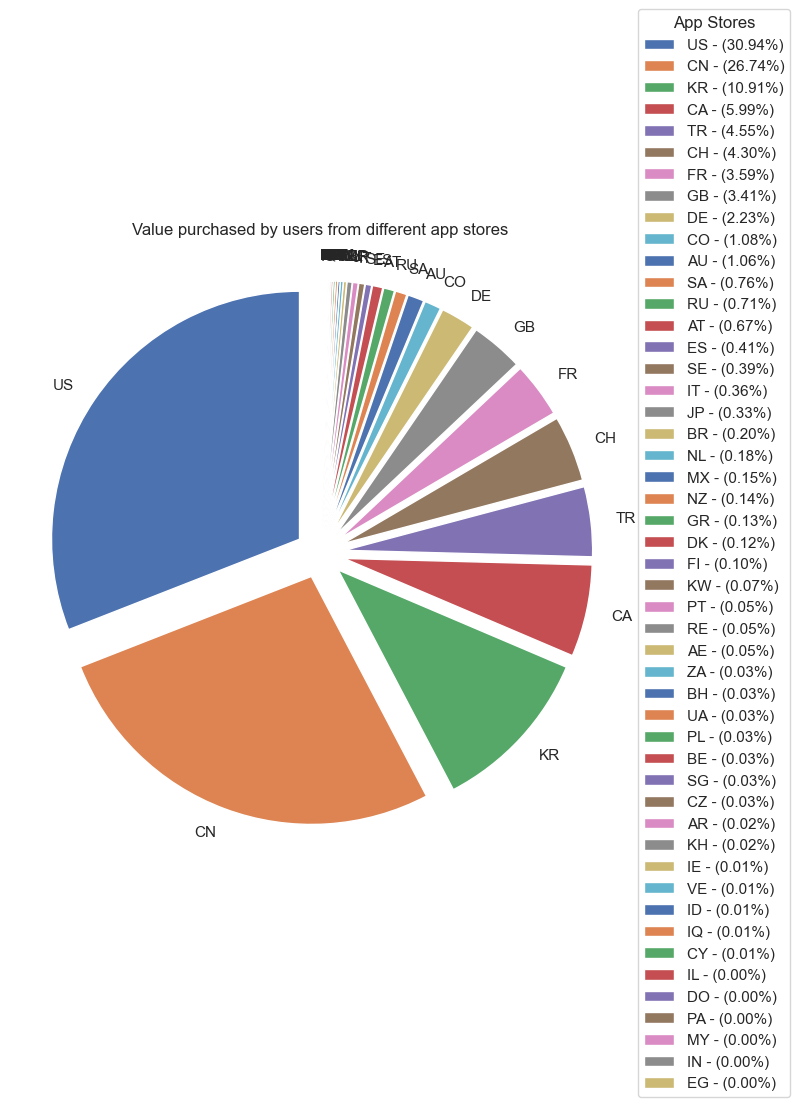

In [45]:
plt.figure(figsize=(8, 10))
sns.set(style="whitegrid")
plt.title("Value purchased by users from different app stores")
wedges, texts = plt.pie(sum_per_country['iap_price_usd_cents'], labels=sum_per_country['country_code'], startangle=90, explode=[0.1 for i in range(len(sum_per_country))])

legend_labels = [f'{label} - ({100*value/sum_per_country["iap_price_usd_cents"].sum():.2f}%)' for label, value in zip(sum_per_country['country_code'], sum_per_country['iap_price_usd_cents'])]
plt.legend(wedges, legend_labels, title="App Stores", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

plt.show()

as you can see, most of users (more than 57%) are from USA and China